In [1]:
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import Descriptors

import matplotlib.pyplot as plt


In [2]:
# Load dataset
df = pd.read_csv("../data/compounds.csv")

# Inspect
df.head()


,compound_id,smiles
0,CMPD_001,CCOC(=O)C1=CC=CC=C1
1,CMPD_002,CCN(CC)CCOC1=CC=CC=C1
2,CMPD_003,CC(C)NCC(O)COC1=CC=CC=C1
3,CMPD_004,CCOC1=NC=NC2=NC=CN12
4,CMPD_005,CC(C)OC(=O)C1=CC=CC=C1


In [3]:
def validate_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol

df["mol"] = df["smiles"].apply(validate_smiles)

# Remove invalid molecules
df = df[df["mol"].notnull()].reset_index(drop=True)

df.head()


,compound_id,smiles,mol
0,CMPD_001,CCOC(=O)C1=CC=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x00000201A7B...
1,CMPD_002,CCN(CC)CCOC1=CC=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x00000201A7B...
2,CMPD_003,CC(C)NCC(O)COC1=CC=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x00000201A7B...
3,CMPD_004,CCOC1=NC=NC2=NC=CN12,<rdkit.Chem.rdchem.Mol object at 0x00000201A7B...
4,CMPD_005,CC(C)OC(=O)C1=CC=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x00000201A7B...


In [4]:
def compute_descriptors(mol):
    return {
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "HBD": Descriptors.NumHDonors(mol),
        "HBA": Descriptors.NumHAcceptors(mol),
        "TPSA": Descriptors.TPSA(mol)
    }

descriptor_df = df["mol"].apply(compute_descriptors).apply(pd.Series)

df = pd.concat([df, descriptor_df], axis=1)

df.head()


,compound_id,smiles,mol,MolWt,LogP,HBD,HBA,TPSA
0,CMPD_001,CCOC(=O)C1=CC=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x00000201A7B...,150.177,1.8633,0.0,2.0,26.30
1,CMPD_002,CCN(CC)CCOC1=CC=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x00000201A7B...,193.290,2.4072,0.0,2.0,12.47
2,CMPD_003,CC(C)NCC(O)COC1=CC=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x00000201A7B...,209.289,1.4243,2.0,3.0,41.49
3,CMPD_004,CCOC1=NC=NC2=NC=CN12,<rdkit.Chem.rdchem.Mol object at 0x00000201A7B...,164.168,0.5230,0.0,5.0,52.31
4,CMPD_005,CC(C)OC(=O)C1=CC=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x00000201A7B...,164.204,2.2518,0.0,2.0,26.30


In [5]:
def lipinski_filter(row):
    conditions = [
        row["MolWt"] <= 500,
        row["LogP"] <= 5,
        row["HBD"] <= 5,
        row["HBA"] <= 10
    ]
    return sum(conditions)

df["lipinski_score"] = df.apply(lipinski_filter, axis=1)

df.head()


,compound_id,smiles,mol,MolWt,LogP,HBD,HBA,TPSA,lipinski_score
0,CMPD_001,CCOC(=O)C1=CC=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x00000201A7B...,150.177,1.8633,0.0,2.0,26.30,4
1,CMPD_002,CCN(CC)CCOC1=CC=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x00000201A7B...,193.290,2.4072,0.0,2.0,12.47,4
2,CMPD_003,CC(C)NCC(O)COC1=CC=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x00000201A7B...,209.289,1.4243,2.0,3.0,41.49,4
3,CMPD_004,CCOC1=NC=NC2=NC=CN12,<rdkit.Chem.rdchem.Mol object at 0x00000201A7B...,164.168,0.5230,0.0,5.0,52.31,4
4,CMPD_005,CC(C)OC(=O)C1=CC=CC=C1,<rdkit.Chem.rdchem.Mol object at 0x00000201A7B...,164.204,2.2518,0.0,2.0,26.30,4


In [6]:
# Normalize selected properties
df["norm_logp"] = (df["LogP"] - df["LogP"].min()) / (df["LogP"].max() - df["LogP"].min())
df["norm_tpsa"] = (df["TPSA"] - df["TPSA"].min()) / (df["TPSA"].max() - df["TPSA"].min())

# Simple scoring function
df["priority_score"] = (
    0.5 * df["lipinski_score"] +
    0.25 * (1 - df["norm_logp"]) +
    0.25 * df["norm_tpsa"]
)

df_sorted = df.sort_values("priority_score", ascending=False)

df_sorted[["compound_id", "priority_score"]].head()


,compound_id,priority_score
3,CMPD_004,2.500000
2,CMPD_003,2.318096
7,CMPD_008,2.196234
9,CMPD_010,2.189687
0,CMPD_001,2.167247


In [7]:
df_sorted.to_csv("../outputs/ranked_compounds.csv", index=False)


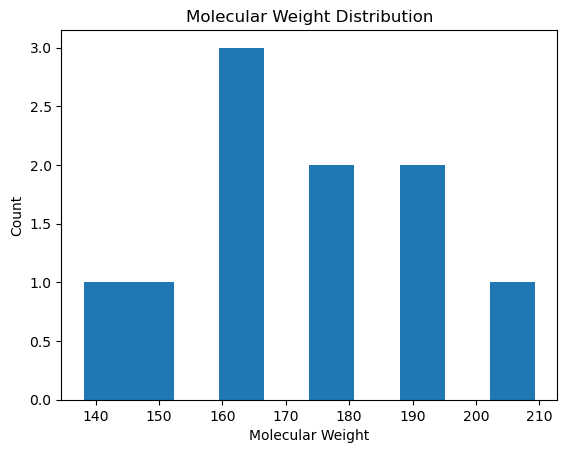

In [8]:
plt.figure()
plt.hist(df["MolWt"], bins=10)
plt.xlabel("Molecular Weight")
plt.ylabel("Count")
plt.title("Molecular Weight Distribution")
plt.show()


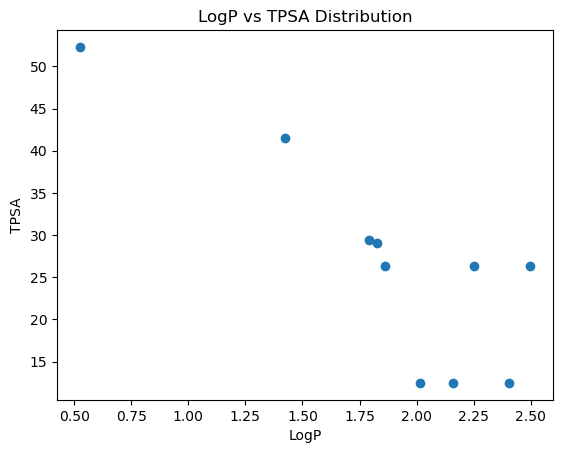

In [9]:
plt.figure()
plt.scatter(df["LogP"], df["TPSA"])
plt.xlabel("LogP")
plt.ylabel("TPSA")
plt.title("LogP vs TPSA Distribution")
plt.show()


In [10]:
plt.figure()
plt.scatter(df["LogP"], df["TPSA"])
plt.xlabel("LogP")
plt.ylabel("TPSA")
plt.title("LogP vs TPSA Distribution")
plt.savefig("../outputs/plots/logp_vs_tpsa.png")
plt.close()
